In [1]:
#Importar bibliotecas
import pandas as pd
import seaborn as sns
import psycopg2 as pg2
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings("ignore")

In [2]:
#Conectando com o PostgreSQL
conn = pg2.connect(database='DP6', user='postgres', password='200613')
cur=conn.cursor()
#Query no PostgreSQL
cur.execute('''
    SELECT q0.fullvisitorid, q0.receita,q0.qt_de_transações,
    q0.media_por_transação,q1.qt_de_sessões_conversão,q2.qt_de_sessões
    FROM (SELECT fullvisitorid, 
        SUM(revenue) AS Receita,
        COUNT(fullvisitorid) AS qt_de_transações,
        AVG(revenue) AS media_por_transação
        FROM hits
        GROUP BY (fullvisitorid)) 
        AS q0
    INNER JOIN (SELECT sessions.fullvisitorid, 
        COUNT(DISTINCT sessions.visitnumber) AS qt_de_sessões_conversão
        FROM sessions
        INNER JOIN hits
        ON hits.fullvisitorid = sessions.fullvisitorid
        WHERE hits.visitid = sessions.visitid 
        GROUP BY sessions.fullvisitorid) 
        AS q1
    ON q0.fullvisitorid = q1.fullvisitorid
    LEFT OUTER JOIN (SELECT fullvisitorid,
        COUNT(visitid) AS qt_de_sessões
        FROM sessions
        GROUP BY fullvisitorid) 
        AS q2
    ON q0.fullvisitorid = q2.fullvisitorid
    ''')
#Fechando conexão
data_base=cur.fetchall()
atv1=pd.DataFrame(data_base,columns=['fullvisitorid', 'Receita','Qt_de_transações',
'Media_por_transação','Qt_de_sessões_conversão','Qt_de_sessões'])
cur.close()
conn.commit()

In [3]:
#Conectando com o PostgreSQL
conn = pg2.connect(database='DP6', user='postgres', password='200613')
cur=conn.cursor()
#Query no PostgreSQL
cur.execute('''
    SELECT DISTINCT q1.fullvisitorid, sessions.geonetwork_country,
    sessions.geonetwork_continent
    FROM (SELECT sessions.fullvisitorid, 
        COUNT(DISTINCT sessions.visitnumber) AS qt_de_sessões_conversão
        FROM sessions
        INNER JOIN hits
        ON hits.fullvisitorid = sessions.fullvisitorid
        WHERE hits.visitid = sessions.visitid 
        GROUP BY sessions.fullvisitorid) AS q1
    INNER JOIN sessions
    ON q1.fullvisitorid = sessions.fullvisitorid
    ORDER BY q1.fullvisitorid
    ''')
#Fechando conexão
data_base=cur.fetchall()
atv2=pd.DataFrame(data_base,columns=['fullvisitorid', 'geonetwork_country',
'geonetwork_continent'])
cur.close()
conn.commit()

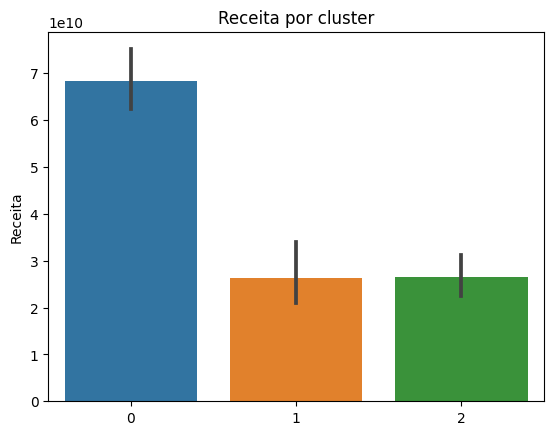

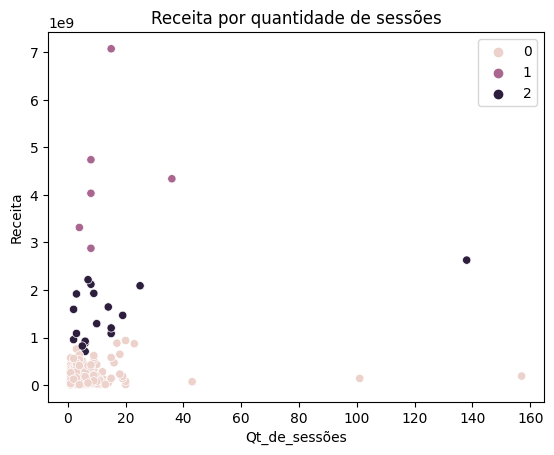

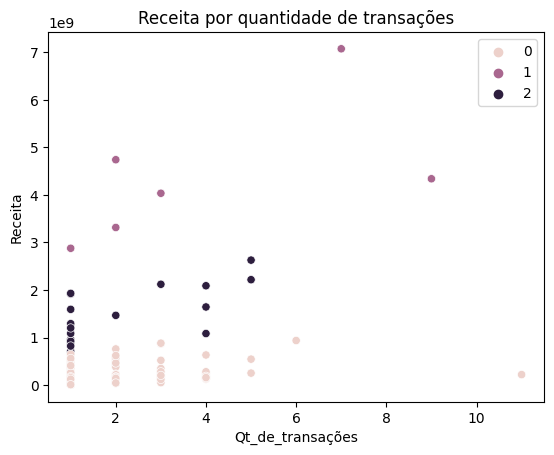

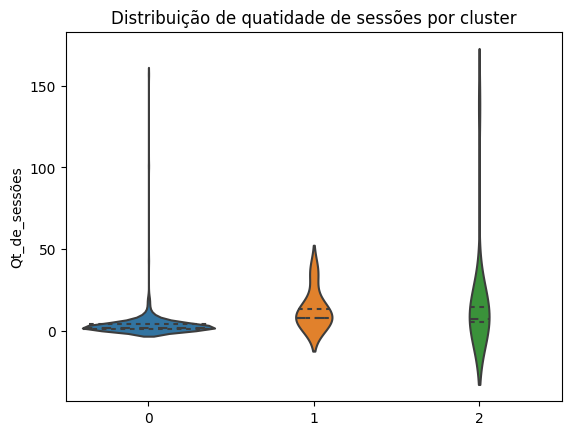

In [38]:
#Clusterizando clientes por receita e média por transação
amostra=atv1[['Media_por_transação','Qt_de_transações','Receita','Qt_de_sessões']]
km = KMeans(n_clusters=3)
label=km.fit_predict(amostra)
#Plotando resultados
sns.barplot(x=label, y='Receita',estimator=sum, data=amostra)
plt.title('Receita por cluster')
plt.show()
sns.scatterplot(data=amostra, x='Qt_de_sessões',y='Receita',hue=label)
plt.title('Receita por quantidade de sessões')
plt.show()
sns.scatterplot(data=amostra, x='Qt_de_transações',y='Receita',hue=label)
plt.title('Receita por quantidade de transações')
plt.show()
sns.violinplot(data=amostra, x=label , y='Qt_de_sessões',inner='quartile')
plt.title('Distribuição de quatidade de sessões por cluster')
plt.show()

In [ ]:
#No geral o número de transações é bem variável
#Da pra perceber que o kmeans usa praticamente só a receita para clusterizar
#Podemos listar três tipos de clientes:
# 1º Os que gastam pouco no geral
# 2º Os que gastam uma quantia média no geral
# 3º E os que gastam uma grande quantia

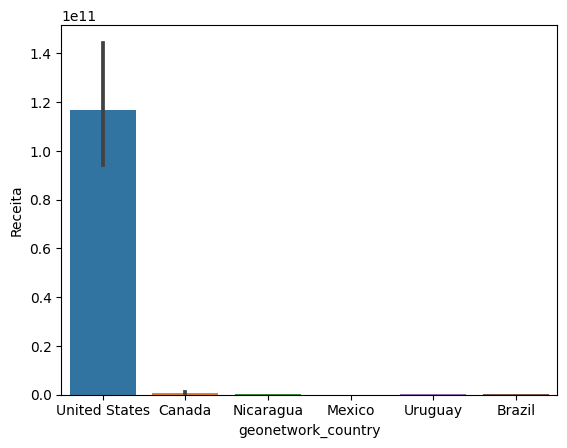

In [7]:
#Entendendo de qual país vem a maior receita
atv3=pd.merge(left=atv1,right=atv2,how='inner',on='fullvisitorid')
atv3=atv3[atv3['geonetwork_continent']=='Americas']
sns.barplot(x='geonetwork_country',y='Receita',estimator=sum,data=atv3)
plt.show()